In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('default')

In [478]:
%matplotlib inline

In [481]:
# 1. groupby count null value 
df1 = pd.DataFrame(dict(A=[1,2]*3, B=[1,2,None,4,None,None]))
df1.groupby(by = 'A')['B'].apply(lambda x: x.isnull().sum())
df1['B'].isnull().groupby(df1['A']).sum()
df1['A'][df1['B'].isnull()].value_counts()

# 1.1. difference between apply & transform
# https://stackoverflow.com/questions/27517425/apply-vs-transform-on-a-group-object

# Objects passed to the function are Series objects whose index is
# either the DataFrame’s index (axis=0) or the DataFrame’s columns
# (axis=1). By default (result_type=None), the final return type
# is inferred from the return type of the applied function. Otherwise,
# it depends on the result_type argument.

1    2
2    1
Name: A, dtype: int64

In [491]:
# from 2 to 6: 
# https://codeutility.org/python-identifying-consecutive-nans-with-pandas-stack-overflow/
# 2. Get the length of consecutive nan
data = pd.Series([np.nan,1,1,1,1,1,np.nan,np.nan,np.nan,1,1,np.nan,np.nan])
na_groups = data.notna().cumsum()[data.isna()] # notna로 cumsum진행 -> isna로 boolean 인덱싱 수행. 
lengths_consecutive_na = na_groups.groupby(na_groups).agg(len) # 중복된 값의 개수 = na의 개수
longest_na_gap = lengths_consecutive_na.max() # 가장 큰 수
longest_na_gap

3

In [492]:
# 3. count total number of nan in certain column
# two way:
# 1) len(column) - column.count()
# 2) column.isnull().sum()
print(len(df1['B']) - df1['B'].count())
print(df1['B'].isnull().sum())

3
3


In [493]:
# 4. find where consecutive null occurs
df2 = pd.DataFrame({'a':[1,3,np.NaN, np.NaN, 4, np.NaN, 6,7,8]})
df2[df2['a'].isnull() & df2['a'].shift(1).isnull()]

,a
3,NaN


In [494]:
# 5. add count consecutive null column
df3 = pd.DataFrame({'a':[1,2,np.NaN, np.NaN, np.NaN, 6,7,8,9,10,np.NaN,np.NaN,13,14]})
df3['a'].isnull().astype(int).groupby(df3['a'].notnull().astype(int).cumsum()).sum()
# df3['a'].isnull().astype(int).groupby(df3['a'].notnull().astype(int)).groups
## 해석: notnull -> cumsum을 진행하면, 값이 동일한 행들이 존재. 그 동일한 행들이 바로 null의 index.
## isnull -> null이 존재하는 index에 1이 존재하고 있음.
## notnull.astype(int).cumsum을 기준으로 null을 groupby하면, 아래와 같이 그룹핑 됨.
## 1:[0], 2:[0, 1, 1, 1], 3:[0], 4:[0], 5:[0], 6:[0], 7:[0,1,1], 8:[0], 9:[0]
## 그러므로 그뤂핑된 객체에 sum을 진행하면, consecutive null 의 총 '개수'를 알 수 있음.
## 만약 consecutive null 이 발생한 원래 index 위치를 알고 싶다면? sum을 cumsum으로 바꿔주면 해결
df3['a'].isnull().astype(int).groupby(df3['a'].notnull().astype(int).cumsum()).cumsum()
# 해당 결과를 기존 테이블에 concat 진행
df3_ = pd.concat([df3, 
        (
         df3['a'].isnull().astype(int)
          .groupby(df3['a'].notnull().astype(int).cumsum())
          .cumsum().to_frame('consec_count')
        )
          ], axis = 1)
df3_

,a,consec_count
0,1.0,0
1,2.0,0
2,NaN,1
3,NaN,2
4,NaN,3
5,6.0,0
6,7.0,0
7,8.0,0
8,9.0,0
9,10.0,0


In [3]:
# 6. count consecutive nan of groupby series object
def count_consec_nan(array):
    consec_cnt = array.isnull().astype(int).groupby(array.notnull().astype(int).cumsum()).cumsum()
    print(consec_cnt)
    return consec_cnt
# groupby series object는 isnull 함수가 없기 때문에, 다음과 같은 code는 실행이 되지 않는다.
# df.groupy('A')['B'].agg(count_consec_nan_func)
df4 = pd.DataFrame({'a':[1,3,np.NaN, np.NaN, 4, np.NaN, 6,7,8, 10],
                   'b': ['q','w','q','t','q','w','q','q','w', np.nan]})
df4['new'] = df4.groupby('b')['a'].apply(count_consec_nan)
df4
# 6.1. count consecutive same value of groupby series object
# (df['price_avg'] == df['price_avg_shift_']).groupby(
#     (df['price_avg'] != df['price_avg_shift_']).cumsum()
# ).cumsum()

0    0
2    1
4    0
6    0
7    0
Name: q, dtype: int64
3    1
Name: t, dtype: int64
1    0
5    1
8    0
Name: w, dtype: int64


,a,b,new
0,1.0,q,0.0
1,3.0,w,0.0
2,NaN,q,1.0
3,NaN,t,1.0
4,4.0,q,0.0
5,NaN,w,1.0
6,6.0,q,0.0
7,7.0,q,0.0
8,8.0,w,0.0
9,10.0,NaN,NaN


In [500]:
# 7. exceed abnormal range
sample_df = pd.read_csv('/Users/cho-eungi/Practice/CSV/airline_stats.csv')
sample_df

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American
3,12.100000,11.033333,0.000000,American
4,7.333333,3.365591,1.774194,American
...,...,...,...,...
33463,6.186422,8.798491,1.651940,Southwest
33464,9.522167,3.591133,0.261084,Southwest
33465,9.164179,2.664179,0.343284,Southwest
33466,5.152293,1.964520,0.122817,Southwest


In [ ]:
def exceed_iqr(array):
    iqr = array.quantile(.75) - array.quantile(.25)
    threshold_max = array.quantile(.75) + 1.5*iqr
    threshold_min = array.quantile(.25) - 1.5*iqr
    if threshold_min < 0:
        threshold_min = 0
    
    check_col = []
    for i in array:
        if i > threshold_max or i < threshold_min:
            check_col.append(1)
        else:
            check_col.append(0)
    return np.asarray(check_col)
    
sample_df['new'] = sample_df.groupby(by = 'airline')['pct_carrier_delay'].transform(exceed_iqr)

sample_df.loc[sample_df['new'] == 1]

In [502]:
# 8. count vs value_counts
print(sample_df.count())
print(sample_df['pct_carrier_delay'].value_counts())
print(sample_df['pct_carrier_delay'].value_counts(bins = 10))

# 9. groupby + function
print(sample_df.groupby(by = 'airline').groups) # group + each index
def compare(idx):
    return sample_df.loc[idx].pct_carrier_delay > sample_df.loc[idx].pct_atc_delay
## function을 통해 groupby 진행하기
sample_df.groupby(compare).groups
## groupby 된 object에 함수 적용하기
sample_df.groupby('airline')['pct_carrier_delay'].agg(lambda x: x.value_counts().sort_values().index[0])
## groupby 된 object에 대해 순위매기기
sample_df = sample_df.sort_values(by = ['airline', 'date'])
sample_df['rank'] = sample_df.groupby('airline')['date'].rank("dense", ascending = True)


pct_carrier_delay    33440
pct_atc_delay        33440
pct_weather_delay    33440
airline              33468
dtype: int64
0.000000     982
3.225806     134
3.333333      80
6.451613      54
6.666667      46
            ... 
10.346154      1
13.840708      1
5.776187       1
2.272619       1
3.964393       1
Name: pct_carrier_delay, Length: 26916, dtype: int64
(-0.101, 10.0]    26919
(10.0, 20.0]       6129
(20.0, 30.0]        325
(30.0, 40.0]         43
(40.0, 50.0]         14
(90.0, 100.0]         5
(60.0, 70.0]          2
(50.0, 60.0]          1
(70.0, 80.0]          1
(80.0, 90.0]          1
Name: pct_carrier_delay, dtype: int64
{'Alaska': [79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 

{False: [6, 10, 15, 19, 20, 24, 26, 32, 33, 34, 35, 36, 37, 46, 50, 66, 79, 80, 82, 83, 84, 85, 86, 90, 91, 92, 93, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 113, 115, 117, 119, 120, 122, 124, 129, 130, 137, 138, 143, 145, 146, 147, 148, 149, 151, 154, 156, 158, 161, 162, 164, 169, 172, 174, 176, 177, 178, 183, 184, 185, 186, 189, 190, 193, 194, 196, 198, 199, 200, 202, 203, 204, 206, 207, 211, 212, 213, 214, 216, 217, 219, 221, 222, 223, 226, 227, ...], True: [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 21, 22, 23, 25, 27, 28, 29, 30, 31, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 81, 87, 88, 89, 94, 95, 100, 107, 112, 114, 116, 118, 121, 123, 125, 126, 127, 128, 131, 132, 133, 134, 135, 136, 139, 140, 141, 142, 144, 150, 152, 153, 155, 157, 159, 160, 163, ...]}

In [467]:
def outlier_cnt(row, sigma=2, display_plot = False):
    # type(row) - np.ndarray
    row = pd.DataFrame(row)
    average = row.rolling(window = len(row), min_periods = 1).mean()
    N = row - average
    std = N.std().iat[0]

    outlier_lst = []
    for i in range(len(row)):
        if (row.iat[i, 0] > average.iat[i, 0] + sigma * std) or (row.iat[i, 0] < average.iat[i, 0] - sigma * std):
            outlier_lst.append(row.iat[i, 0])
    
    if display_plot is True:
        plt.plot(row)
        plt.plot(average)
        plt.plot(average - std * sigma, '--', color='#ff0000')
        plt.plot(average + std * sigma, '--', color='#ff0000')
        plt.xlabel('Time (weeks)')
        plt.ylabel('Price')
        plt.title('Outlier detection (sigma=' + str(sigma) + ')')
        plt.legend(['Row', 'Moving average', 'Lower bound', 'Upper bound'])

        plt.show()
        
    return len(outlier_lst)

# df_test['cnt'] = df_test.apply(lambda row: outlier_cnt(row.values[~np.isnan(row.values)]), axis = 1)

In [512]:
# Moving Average using numpy
ar = np.array(range(6))
def moving_average(ndarray, window=3):
    cumsum_array = np.cumsum(ndarray, dtype=float)
    avg_array = (cumsum_array[window:] - cumsum_array[:-window]) / window
    ndarray = ndarray[:window]
    return np.concatenate([ndarray, avg_array])
#     return ret[window - 1:] / window
moving_average(ar, window = 2)

array([0. , 1. , 1.5, 2.5, 3.5, 4.5])

In [514]:
df3


,a
0,1.0
1,2.0
2,NaN
3,NaN
4,NaN
5,6.0
6,7.0
7,8.0
8,9.0
9,10.0


In [536]:
is_nan = df3['a'].isna()
df3['isna'] = df3['a'].isna()
df3['isna_shift'] = df3['a'].isna().shift()
df3['Ne?'] = np.where(df3['isna'] != (df3['isna_shift']), True, False) # 바뀌는 구간 찾기
df3['cumsum'] = df3['Ne?'].cumsum()
df3

,a,isna,isna_shift,Ne?,cumsum
0,1.0,False,NaN,True,1
1,2.0,False,False,False,1
2,NaN,True,False,True,2
3,NaN,True,True,False,2
4,NaN,True,True,False,2
5,6.0,False,True,True,3
6,7.0,False,False,False,3
7,8.0,False,False,False,3
8,9.0,False,False,False,3
9,10.0,False,False,False,3


In [539]:
df3['a'][is_nan].groupby(df3['cumsum']).groups

{2: [2, 3, 4], 4: [10, 11]}

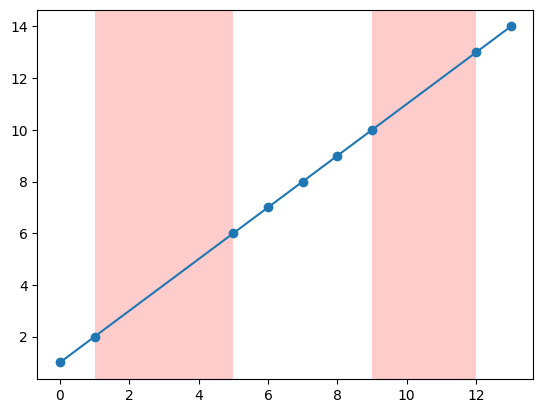

In [552]:
gap_lst = df3['a'][is_nan].groupby(df3['cumsum']).aggregate(
    lambda x: (
        x.index[0] - 1,
        x.index[-1] + 1
    )
).values

smask = np.isfinite(df3['a'])

plt.plot(df3['a'].index[smask], df3['a'][smask], marker = 'o')

for gap in gap_lst:
    plt.axvspan(gap[0], gap[1], facecolor='r', alpha=0.2)
plt.show()

In [ ]:
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df3[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(days=-7),
        x.index[-1] + pd.DateOffset(days=+7)
    )
)["price_avg"].values